# Full SROIE Text Recognition Pipeline: Preprocessing, Training, Testing, and Saving Model

In [2]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

## 1. Setup and Imports

In [3]:
# Cell 1: Imports and Setup

import os
# Attempt to disable XLA auto-JIT more broadly
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
# Also try to disable JIT compilation at the TF config level
import tensorflow as tf
#try:
#    tf.config.optimizer.set_jit(False)
#    print("Attempted to tf.config.optimizer.set_jit(False)")
#except AttributeError:
#    print("tf.config.optimizer.set_jit not available in this TF version (might be TF1.x specific or changed path). Continuing...")


#tf.debugging.enable_check_numerics()
#print("TF Global Numerics Check ENABLED")
#print("Attempted to disable XLA Auto JIT globally.")

# ... rest of your imports (numpy, matplotlib, keras, datasets, etc.)
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
from functools import partial

print(f"TensorFlow version: {tf.__version__}")
# print(f"Keras version: {keras.__version__}") # If you're using standalone Keras

TensorFlow version: 2.18.0


## 1.1 Mount Google Drive (if using Google Colab)

In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    GOOGLE_DRIVE_MOUNTED = True
    print("Google Drive mounted successfully.")
except ImportError:
    GOOGLE_DRIVE_MOUNTED = False
    print("Not running in Google Colab or Google Drive could not be mounted.")

Mounted at /content/drive
Google Drive mounted successfully.


## 2. Configuration

In [5]:
# Cell 2: Configuration

# --- Configuration for Image Preprocessing ---
TARGET_PREPROC_HEIGHT = 64

# MODEL_DOWNAMPLE_FACTOR will be 2 if using the extremely simplified CNN in Cell 7
MODEL_DOWNAMPLE_FACTOR = 2
# MAX_MODEL_WIDTH needs to ensure logit_length >= 68
# logit_length = MAX_MODEL_WIDTH // MODEL_DOWNAMPLE_FACTOR
# MAX_MODEL_WIDTH // 2 >= 68  => MAX_MODEL_WIDTH >= 136
MAX_MODEL_WIDTH = 144 # Gives logit_length = 144/2 = 72

# --- Configuration for Model and Training ---
BATCH_SIZE = 16
EPOCHS = 10 # Keep low for testing

# --- Configuration for Saving Model ---
MODEL_SAVE_NAME = "sroie_crnn_model.keras"

if GOOGLE_DRIVE_MOUNTED:
    base_drive_path = '/content/drive/MyDrive/'
    relative_model_path = 'Colab Notebooks/Models'
    DRIVE_MODEL_SAVE_DIR = os.path.join(base_drive_path, relative_model_path)
    DRIVE_MODEL_SAVE_PATH = os.path.join(DRIVE_MODEL_SAVE_DIR, MODEL_SAVE_NAME)
    print(f"Model save directory set to: {DRIVE_MODEL_SAVE_DIR}")
    print(f"Model will be saved to: {DRIVE_MODEL_SAVE_PATH}")
else:
    DRIVE_MODEL_SAVE_DIR = '.'
    DRIVE_MODEL_SAVE_PATH = MODEL_SAVE_NAME
    print(f"Model will be saved locally to: {DRIVE_MODEL_SAVE_PATH}")

Model save directory set to: /content/drive/MyDrive/Colab Notebooks/Models
Model will be saved to: /content/drive/MyDrive/Colab Notebooks/Models/sroie_crnn_model.keras


## 3. Load and Split Dataset

In [6]:
# Cell 3: Load and Split Dataset

# Load datasets
train_dataset_hf_full = load_dataset("priyank-m/SROIE_2019_text_recognition", split="train")
test_dataset_hf  = load_dataset("priyank-m/SROIE_2019_text_recognition", split="test")

# --- FOR FASTER DEBUGGING: Use a smaller subset ---
# To use a subset (e.g., 5% of data for ~94 steps per epoch if BATCH_SIZE=16 for original full train)
subset_percentage = 0.025
# Comment out the next line to use the full training dataset
train_dataset_hf_full = train_dataset_hf_full.select(range(int(len(train_dataset_hf_full) * subset_percentage)))
if 'subset_percentage' in locals() and subset_percentage < 1.0:
    print(f"DEBUG MODE: Using only {subset_percentage*100:.1f}% of the training data: {len(train_dataset_hf_full)} samples.")
# --- END DEBUG SUBSET ---


validation_dataset_size = int(len(train_dataset_hf_full) * 0.1) # 10% of the (potentially subsetted) training data

# Ensure validation_dataset_size and remaining training data are at least 1, handle small dataset cases
if len(train_dataset_hf_full) == 0:
    raise ValueError("Training dataset is empty after subsetting or loading.")
if validation_dataset_size == 0 and len(train_dataset_hf_full) > 0:
    validation_dataset_size = 1 # At least one sample for validation if possible
if validation_dataset_size >= len(train_dataset_hf_full): # if val_size would leave no training data
    validation_dataset_size = len(train_dataset_hf_full) // 2 # or some other fraction
    if validation_dataset_size == 0 and len(train_dataset_hf_full) > 0 : validation_dataset_size = 1


validation_dataset_hf = train_dataset_hf_full.select(range(validation_dataset_size))
train_dataset_hf = train_dataset_hf_full.select(range(validation_dataset_size, len(train_dataset_hf_full)))

# Final check if train_dataset_hf became empty after split
if len(train_dataset_hf) == 0 and len(train_dataset_hf_full) > 0:
    print("Warning: train_dataset_hf is empty after split, using a small part of original for training.")
    # This can happen if subsetting makes train_dataset_hf_full too small
    # Re-adjust: make train at least 1, val at least 1 if possible
    if len(train_dataset_hf_full) > 1:
        train_dataset_hf = train_dataset_hf_full.select(range(1)) # train gets 1 sample
        validation_dataset_hf = train_dataset_hf_full.select(range(1,len(train_dataset_hf_full))) # val gets the rest
        if len(validation_dataset_hf) == 0: # if only 1 sample total
             validation_dataset_hf = train_dataset_hf # use same for val
    elif len(train_dataset_hf_full) == 1:
        train_dataset_hf = train_dataset_hf_full
        validation_dataset_hf = train_dataset_hf_full


print(f"Full original SROIE train dataset size: {len(load_dataset('priyank-m/SROIE_2019_text_recognition', split='train'))}")
print(f"Effective full train dataset size (after potential subsetting): {len(train_dataset_hf_full)}")
print(f"Using final train dataset size: {len(train_dataset_hf)}")
print(f"Validation dataset size: {len(validation_dataset_hf)}")
print(f"Test dataset size: {len(test_dataset_hf)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/924 [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/116M [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33626 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/18704 [00:00<?, ? examples/s]

DEBUG MODE: Using only 2.5% of the training data: 840 samples.
Full original SROIE train dataset size: 33626
Effective full train dataset size (after potential subsetting): 840
Using final train dataset size: 756
Validation dataset size: 84
Test dataset size: 18704


## 4. Character Set and Label Encoding

In [7]:
# Cell 4: Character Set and Label Encoding

# Use the text from the full training dataset to build a robust vocabulary
# If you used subsetting in Cell 3 for train_dataset_hf_full, this will use that subset.
# For a truly complete vocabulary, load the 'text' column from the original full dataset again if needed.
# For now, assume train_dataset_hf_full (potentially subsetted) is sufficient for vocab.
all_texts_for_vocab = train_dataset_hf_full['text']

characters = set()
for text in all_texts_for_vocab:
    characters.update(list(str(text))) # Ensure text is string
characters = sorted(list(characters))

print(f"Found {len(characters)} unique characters: {''.join(characters)}")

char_to_num = {char: i + 1 for i, char in enumerate(characters)} # 0 is reserved for CTC blank
num_to_char = {i + 1: char for i, char in enumerate(characters)}
CTC_BLANK_INDEX = 0
num_to_char[CTC_BLANK_INDEX] = "<BLANK>"

VOCAB_SIZE = len(characters) + 1
print(f"Vocabulary size (including CTC blank): {VOCAB_SIZE}")

# Determine max label length for padding y_true.
# This should be based on the longest actual label string in the *entire dataset* (e.g., 68).
# The current all_texts_for_vocab might be from a subset.
# For robustness, let's re-fetch all texts just for this calculation if not too slow.
# If load_dataset is slow, you can manually set MAX_LABEL_LENGTH = 68 if you are certain.
# temp_all_texts_for_max_len = load_dataset("priyank-m/SROIE_2019_text_recognition", split="train")['text']
# MAX_LABEL_LENGTH = 0
# for text in temp_all_texts_for_max_len:
#     if len(str(text)) > MAX_LABEL_LENGTH:
#         MAX_LABEL_LENGTH = len(str(text))
# print(f"Max label length from full dataset (for y_true padding): {MAX_LABEL_LENGTH}")

# Simpler: use the max from the current all_texts_for_vocab, assuming it's representative
# Or if you know the true max is 68, you can hardcode it for safety:
MAX_LABEL_LENGTH = 68
print(f"Using MAX_LABEL_LENGTH (for y_true padding): {MAX_LABEL_LENGTH}")
# This ensures y_true arrays are padded to at least 68.
# The actual encoded length of a label can be shorter.

Found 59 unique characters:  !"#%&'()*,-./0123456789:<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^
Vocabulary size (including CTC blank): 60
Using MAX_LABEL_LENGTH (for y_true padding): 68


## 5. Image and Label Preprocessing Function

In [8]:
# Cell 5: Image and Label Preprocessing Function

def encode_text_to_labels(text_tensor, char_map_py, max_len_py_for_padding):
    # text_tensor: the string tensor for a single label
    # char_map_py: Python dictionary char -> num
    # max_len_py_for_padding: integer, length to pad the output encoded label array to (e.g., dataset's MAX_LABEL_LENGTH)

    if tf.is_tensor(text_tensor) and text_tensor.dtype == tf.string:
        text = text_tensor.numpy().decode('utf-8')
    else:
        text = str(text_tensor)

    # Optional: Truncate text if it's longer than what model can predict (logit_length)
    # logit_length = MAX_MODEL_WIDTH // MODEL_DOWNAMPLE_FACTOR (from global config in Cell 2)
    # This ensures len(encoded) <= logit_length
    # max_predictable_len = MAX_MODEL_WIDTH // MODEL_DOWNAMPLE_FACTOR
    # if len(text) > max_predictable_len:
    #     text = text[:max_predictable_len]
        # print(f"Warning: Truncated label from original length to {len(text)} to fit model output.")

    encoded = [char_map_py[char] for char in text if char in char_map_py]

    # Pad the encoded label to max_len_py_for_padding (e.g., 68)
    padded_label = np.ones(max_len_py_for_padding, dtype=np.int32) * CTC_BLANK_INDEX
    padded_label[:len(encoded)] = encoded
    return tf.convert_to_tensor(padded_label, dtype=tf.int32), tf.convert_to_tensor(len(encoded), dtype=tf.int32)

def preprocess_and_encode_example(example, char_to_num_map_arg, target_height_arg, max_model_width_arg, model_downsample_factor_arg, max_label_len_for_padding_arg):
    # char_to_num_map_arg: Python char_to_num dictionary
    # target_height_arg: e.g., 64
    # max_model_width_arg: e.g., 144 (from Cell 2)
    # model_downsample_factor_arg: e.g., 2 (from Cell 2)
    # max_label_len_for_padding_arg: e.g., 68 (MAX_LABEL_LENGTH from Cell 4, used for y_true padding)

    image_tensor = example['image']
    text_label_str = example['text']

    image_tensor = tf.squeeze(image_tensor, axis=0)
    text_label_str_squeezed = tf.squeeze(text_label_str, axis=0)

    image_tensor = tf.cast(image_tensor, tf.float32)

    original_shape = tf.shape(image_tensor)
    original_height = original_shape[0]
    original_width = original_shape[1]

    num_channels = tf.shape(image_tensor)[-1]
    if image_tensor.shape.rank == 3 and image_tensor.shape[-1] is not None:
        num_channels = image_tensor.shape[-1]
    else:
        num_channels = 3

    aspect_ratio = tf.cast(original_width, tf.float32) / tf.cast(original_height, tf.float32)
    new_width_float = aspect_ratio * tf.cast(target_height_arg, tf.float32)
    new_width = tf.cast(tf.round(new_width_float), tf.int32)
    new_width = tf.maximum(new_width, 1)

    resized_image = tf.image.resize(image_tensor, [target_height_arg, new_width], method=tf.image.ResizeMethod.BILINEAR)

    current_width_after_resize = tf.shape(resized_image)[1]
    if tf.greater(current_width_after_resize, max_model_width_arg):
        final_image = tf.image.crop_to_bounding_box(resized_image, 0, 0, target_height_arg, max_model_width_arg)
    else:
        padding_width = max_model_width_arg - current_width_after_resize
        paddings = [[0, 0], [0, padding_width], [0, 0]]
        final_image = tf.pad(resized_image, paddings, "CONSTANT", constant_values=0.0)

    final_image = final_image / 255.0

    final_image.set_shape([target_height_arg, max_model_width_arg, num_channels])

    py_func_wrapper = lambda text_tensor_for_py_func: encode_text_to_labels(
        text_tensor_for_py_func,
        char_to_num_map_arg,
        max_label_len_for_padding_arg # Pass the padding length for y_true
    )

    encoded_label, label_length = tf.py_function(
        func=py_func_wrapper,
        inp=[text_label_str_squeezed],
        Tout=[tf.int32, tf.int32]
    )
    encoded_label.set_shape([max_label_len_for_padding_arg])
    label_length.set_shape([])

    # input_length for CTC is the model's output sequence length (logit_length)
    input_length = tf.convert_to_tensor(max_model_width_arg // model_downsample_factor_arg, dtype=tf.int32)
    input_length.set_shape([])

    inputs = {
        "image": final_image,
        "label_length": label_length,
        "input_length": input_length
    }
    return inputs, encoded_label

partial_preprocess_encode_fn = partial(
    preprocess_and_encode_example,
    char_to_num_map_arg=char_to_num, # From Cell 4
    target_height_arg=TARGET_PREPROC_HEIGHT, # From Cell 2
    max_model_width_arg=MAX_MODEL_WIDTH, # From Cell 2
    model_downsample_factor_arg=MODEL_DOWNAMPLE_FACTOR, # From Cell 2
    max_label_len_for_padding_arg=MAX_LABEL_LENGTH # From Cell 4 (e.g., 68)
)

## 6. Create TensorFlow Datasets

In [9]:
print("\nCreating TensorFlow datasets...")

tf_train_dataset_unbatched = train_dataset_hf.to_tf_dataset(
    columns=['image', 'text'],
    shuffle=True,
    batch_size=1,
    prefetch=tf.data.AUTOTUNE
).map(partial_preprocess_encode_fn, num_parallel_calls=tf.data.AUTOTUNE)

tf_validation_dataset_unbatched = validation_dataset_hf.to_tf_dataset(
    columns=['image', 'text'],
    shuffle=False,
    batch_size=1,
    prefetch=tf.data.AUTOTUNE
).map(partial_preprocess_encode_fn, num_parallel_calls=tf.data.AUTOTUNE)

tf_test_dataset_unbatched = test_dataset_hf.to_tf_dataset(
    columns=['image', 'text'],
    shuffle=False,
    batch_size=1,
    prefetch=tf.data.AUTOTUNE
).map(partial_preprocess_encode_fn, num_parallel_calls=tf.data.AUTOTUNE)

print("TensorFlow datasets (unbatched but processed) created.")
print("Train dataset element spec (unbatched):", tf_train_dataset_unbatched.element_spec)

train_ds_batched = tf_train_dataset_unbatched.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_ds_batched = tf_validation_dataset_unbatched.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds_batched = tf_test_dataset_unbatched.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("\nBatched train dataset element spec:", train_ds_batched.element_spec)

print("\n--- Input Data Sanity Check (First Training Batch BEFORE model.fit) ---")
for sample_x_check, sample_y_check in train_ds_batched.take(1):
    image_batch_check = sample_x_check['image']
    print("Image batch shape:", image_batch_check.shape)
    print("Image batch dtype:", image_batch_check.dtype)

    min_val = tf.reduce_min(image_batch_check).numpy()
    max_val = tf.reduce_max(image_batch_check).numpy()
    mean_val = tf.reduce_mean(image_batch_check).numpy()
    std_val = tf.math.reduce_std(image_batch_check).numpy()

    print(f"Image batch min/max pixel values: {min_val:.4f} / {max_val:.4f}")
    print(f"Image batch mean/std pixel values: {mean_val:.4f} / {std_val:.4f}")

    has_nan = tf.reduce_any(tf.math.is_nan(image_batch_check)).numpy()
    has_inf = tf.reduce_any(tf.math.is_inf(image_batch_check)).numpy()
    print(f"Image batch contains NaN: {has_nan}")
    print(f"Image batch contains Inf: {has_inf}")

    print("Labels batch shape:", sample_y_check.shape)
    print("Labels batch dtype:", sample_y_check.dtype)
    print("Sample label (first item, first 15 vals):", sample_y_check[0,:15].numpy())
    print("----------------------------------------------------------------------")
    break


Creating TensorFlow datasets...
TensorFlow datasets (unbatched but processed) created.
Train dataset element spec (unbatched): ({'image': TensorSpec(shape=(64, 144, 3), dtype=tf.float32, name=None), 'label_length': TensorSpec(shape=(), dtype=tf.int32, name=None), 'input_length': TensorSpec(shape=(), dtype=tf.int32, name=None)}, TensorSpec(shape=(68,), dtype=tf.int32, name=None))

Batched train dataset element spec: ({'image': TensorSpec(shape=(None, 64, 144, 3), dtype=tf.float32, name=None), 'label_length': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'input_length': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 68), dtype=tf.int32, name=None))

--- Input Data Sanity Check (First Training Batch BEFORE model.fit) ---
Image batch shape: (16, 64, 144, 3)
Image batch dtype: <dtype: 'float32'>
Image batch min/max pixel values: 0.0000 / 1.0000
Image batch mean/std pixel values: 0.7774 / 0.2849
Image batch contains NaN: False
Image batch contains Inf

## 7. Build the CRNN Model

In [10]:
# Cell 7: Build the CRNN Model (Adjusted from Debug for Training)

def build_crnn_model(input_shape, vocab_size, rnn_units=16): # Renamed function
    img_input = layers.Input(shape=input_shape, name="image", dtype="float32")

    # Layer 1
    x = layers.Conv2D(16, (3, 3), activation="relu",
                      kernel_initializer=keras.initializers.VarianceScaling(scale=0.1),
                      bias_initializer='zeros',
                      padding="same", name="conv1")(img_input)
    # Layer 2 (BN was removed in debug, keep it that way or add it back if desired)
    # x = layers.BatchNormalization(name="bn1")(x)
    # Layer 3
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    new_height = x.shape[1]
    new_width = x.shape[2]
    num_features = x.shape[3]

    if new_height is None or new_width is None or num_features is None:
        raise ValueError(f"Shape component is None after pool1. H:{new_height}, W:{new_width}, F:{num_features}")

    # Layer 4
    x = layers.Reshape(target_shape=(new_width, new_height * num_features), name="reshape1")(x)

    # Layer 5
    x = layers.Dense(16, activation="relu",
                     kernel_initializer=keras.initializers.VarianceScaling(scale=0.1),
                     bias_initializer='zeros', name="dense1")(x)

    # Layer 6
    gru_layer = layers.GRU(rnn_units, return_sequences=True,
                           kernel_initializer=keras.initializers.VarianceScaling(scale=0.1),
                           recurrent_initializer='orthogonal',
                           bias_initializer='zeros',
                           activation='tanh',
                           recurrent_activation='sigmoid',
                           name="gru1")
    x = layers.Bidirectional(gru_layer, name="bigru1")(x)

    # Layer 7
    output_logits = layers.Dense(vocab_size, activation="linear",
                                 kernel_initializer=keras.initializers.VarianceScaling(scale=0.1),
                                 bias_initializer='zeros',
                                 name="logits")(x)

    # Model for actual training outputs only the final logits
    model = keras.Model(
        inputs=img_input,
        outputs=output_logits, # **** CHANGED THIS LINE ****
        name="crnn_training_model" # Optional: give it a distinct name
    )
    return model

# This part is for getting shape info and is fine to keep
example_input_dict_spec, _ = train_ds_batched.element_spec # train_ds_batched from Cell 6
model_input_shape = example_input_dict_spec['image'].shape[1:]
print(f"Determined model input shape for model build: {model_input_shape}")

# You don't need to build crnn_debug_model here anymore if Cell 9 is for actual training.
# crnn_debug_model = build_crnn_model_for_debug(input_shape=model_input_shape, vocab_size=VOCAB_SIZE)
# crnn_debug_model.summary()

Determined model input shape for model build: (64, 144, 3)


## 8. CTC Loss Function

In [11]:
# Cell 8: CTC Loss Function

class CTCLossTFNN(keras.losses.Loss):
    def __init__(self, name="ctc_loss_tfnn"):
        super().__init__(name=name)

    def call(self, y_true, y_pred_logits):
        y_true = tf.cast(y_true, dtype=tf.int32)

        y_pred_logits_finite = tf.where(
            tf.math.is_finite(y_pred_logits),
            y_pred_logits,
            tf.zeros_like(y_pred_logits)
        )
        LOGIT_CLIP_VALUE = 10.0 # Can be adjusted
        y_pred_logits_clipped = tf.clip_by_value(y_pred_logits_finite, -LOGIT_CLIP_VALUE, LOGIT_CLIP_VALUE)

        logits_time_major = tf.transpose(y_pred_logits_clipped, perm=[1, 0, 2])

        label_length_sum = tf.reduce_sum(tf.cast(tf.not_equal(y_true, CTC_BLANK_INDEX), dtype=tf.int32), axis=-1)
        label_length = tf.cast(label_length_sum, dtype=tf.int32)

        current_batch_size = tf.shape(y_true)[0]
        time_steps = tf.shape(logits_time_major)[0]
        logit_length = tf.fill(dims=[current_batch_size], value=time_steps)
        logit_length = tf.cast(logit_length, dtype=tf.int32)

        indices = tf.where(tf.not_equal(y_true, CTC_BLANK_INDEX))
        values = tf.gather_nd(y_true, indices)
        values = tf.cast(values, dtype=tf.int32)

        shape = tf.cast(tf.shape(y_true), tf.int64)
        labels_sparse = tf.SparseTensor(indices, values, shape)

        # REMOVED/COMMENTED OUT tf.print statements for DTypes and Shapes
        # tf.print("--- DTypes and Shapes before tf.nn.ctc_loss ---", summarize=-1)
        # tf.print("labels_sparse.dtype:", labels_sparse.dtype, "shape:", tf.shape(labels_sparse.dense_shape), summarize=-1)
        # tf.print("logits_time_major.dtype:", logits_time_major.dtype, "shape:", tf.shape(logits_time_major), summarize=-1)
        # tf.print("label_length.dtype:", label_length.dtype, "shape:", tf.shape(label_length), summarize=-1)
        # tf.print("logit_length.dtype:", logit_length.dtype, "shape:", tf.shape(logit_length), summarize=-1)
        # tf.print("----------------------------------------------", summarize=-1)

        loss = tf.nn.ctc_loss(
            labels=labels_sparse,
            logits=logits_time_major,
            label_length=label_length,
            logit_length=logit_length,
            logits_time_major=True,
            blank_index=CTC_BLANK_INDEX
        )

        # REMOVED/COMMENTED OUT tf.print for NaN loss check
        # tf.cond(tf.reduce_any(tf.math.is_nan(loss)),
        #         lambda: tf.print("CRITICAL TF.NN.CTC_LOSS: Loss value from tf.nn.ctc_loss IS NaN."),
        #         lambda: tf.constant(False)
        #        )

        return tf.reduce_mean(loss)

ctc_loss_fn = CTCLossTFNN()

## 9. Compile and Train the Model


Rebuilding the CRNN model for training...


Model: "crnn_training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 144, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 144, 16)    │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 72, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape1 (Reshape)              │ (None, 72, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 72, 16)         │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru1 (Bidirectional)          │ (None, 72, 32)         │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ (None, 72, 60)         │         1,980 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,900 (54.30 KB)

 Trainable params: 13,900 (54.30 KB)

 Non-trainable params: 0 (0.00 B)

Model compiled for graph execution (efficient training).

Starting model training for 10 epochs (or until EarlyStopping)...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: image
Received: inputs=['Tensor(shape=(None, 64, 144, 3))']
  warnings.warn(msg)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 256.6898
Epoch 1: val_loss improved from inf to 251.14941, saving model to /content/drive/MyDrive/Colab Notebooks/Models/sroie_crnn_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step - loss: 256.6713 - val_loss: 251.1494 - learning_rate: 1.0000e-04
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 247.1263
Epoch 2: val_loss improved from 251.14941 to 221.26114, saving model to /content/drive/MyDrive/Colab Notebooks/Models/sroie_crnn_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 321s 6s/step - loss: 247.0127 - val_loss: 221.2611 - learning_rate: 1.0000e-04
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 214.4216
Epoch 3: val_loss improved from 221.26114 to 176.46286, saving model to /content/drive/MyDrive/Colab Notebooks/Models/sroie_crnn_model.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 311s 6s/step - loss: 214.2098 - val_loss: 176.4629 - learning_rate: 1.0000e-04
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 171.9140
Epoch 4: val

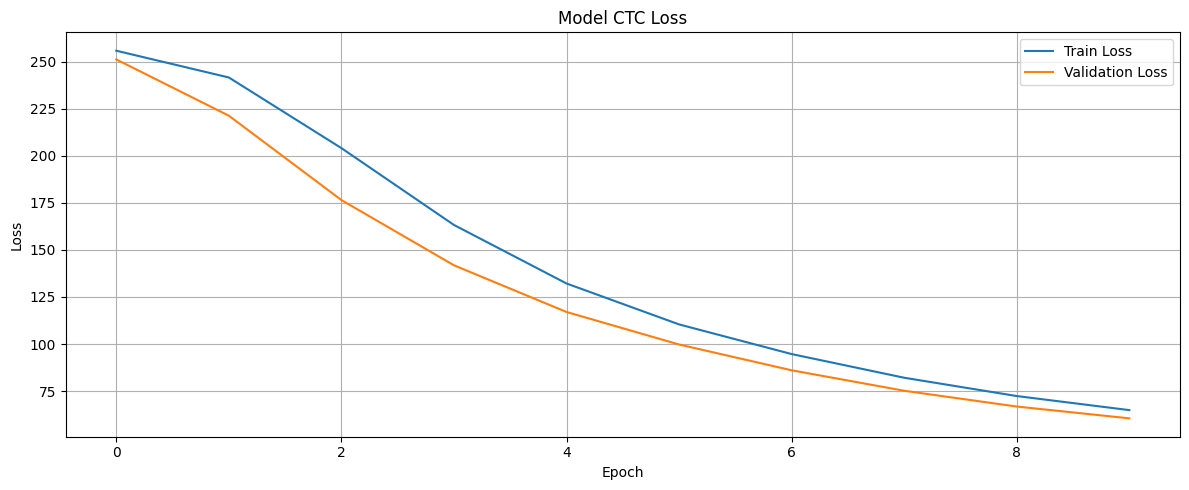

In [12]:
# Cell 9: Compile and Train the CRNN Model (For Actual Training)

print("\nRebuilding the CRNN model for training...")
# Ensure 'build_crnn_model' (defined in Cell 7 or a similar cell)
# is your intended training model architecture.
# 'model_input_shape' and 'VOCAB_SIZE' should be available from previous cells.
crnn_model = build_crnn_model(input_shape=model_input_shape, vocab_size=VOCAB_SIZE)
crnn_model.summary() # Display the model architecture being trained

# --- Optimizer Configuration ---
# Start with a common learning rate, adjust based on training behavior.
# clipvalue can help prevent exploding gradients in RNNs.
initial_learning_rate = 1e-4 # A common starting point
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate, clipvalue=1.0) # Adjust clipvalue if needed

# --- Compile the Model ---
# run_eagerly should be False (default) for efficient training.
crnn_model.compile(optimizer=optimizer, loss=ctc_loss_fn, run_eagerly=False)
print("Model compiled for graph execution (efficient training).")

# --- Callbacks ---
callbacks_list = [
    keras.callbacks.TerminateOnNaN(), # Stops training if loss becomes NaN
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,        # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True, # Restores model weights from the epoch with the best val_loss
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=5,         # Number of epochs with no improvement after which learning rate will be reduced.
        min_lr=1e-6,        # Lower bound on the learning rate.
        verbose=1
    ),
    # Optional: ModelCheckpoint to save the best model found during training
    keras.callbacks.ModelCheckpoint(
        filepath=DRIVE_MODEL_SAVE_PATH, # Ensure DRIVE_MODEL_SAVE_PATH is defined (from Cell 2)
        monitor='val_loss',
        save_best_only=True, # Only save a model if `val_loss` has improved
        save_weights_only=False, # Save the full model
        verbose=1
    )
]

# --- Start Training ---
print(f"\nStarting model training for {EPOCHS} epochs (or until EarlyStopping)...")
# EPOCHS should be defined in your Configuration cell (Cell 2)

history = crnn_model.fit(
    train_ds_batched,
    validation_data=validation_ds_batched,
    epochs=EPOCHS, # Use the global EPOCHS variable
    callbacks=callbacks_list,
    verbose=1 # Or 2 for less output per epoch
)

print("\nTraining complete.")

# --- Plot Training History (if training ran for at least one epoch) ---
if history and history.history:
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss values
    plt.subplot(1, 1, 1) # If only plotting loss
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model CTC Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("History object not populated, possibly due to training interruption or zero epochs completed.")

# Note: The model saved by ModelCheckpoint (DRIVE_MODEL_SAVE_PATH) is the one with the best val_loss.
# The 'crnn_model' instance in memory will have the weights from the last epoch of training
# (unless EarlyStopping with restore_best_weights=True updated them).
# Cell 10 will save the *current state* of crnn_model after fit completes.
# If EarlyStopping restored best weights, then crnn_model and the checkpointed model are the same.

## 10. Save the Trained Model

In [13]:
print(f"Attempting to save model to: {DRIVE_MODEL_SAVE_PATH}")
try:
    # Ensure the directory exists
    if not os.path.exists(DRIVE_MODEL_SAVE_DIR):
        os.makedirs(DRIVE_MODEL_SAVE_DIR)
        print(f"Created directory: {DRIVE_MODEL_SAVE_DIR}")

    crnn_model.save(DRIVE_MODEL_SAVE_PATH)
    print(f"Model saved successfully to {DRIVE_MODEL_SAVE_PATH}")

    # Optional: Verify by listing the file if in Colab and saved to Drive
    if GOOGLE_DRIVE_MOUNTED and os.path.exists(DRIVE_MODEL_SAVE_PATH):
        print("Verifying file in Google Drive (listing using get_ipython().system()):")
        # Use get_ipython().system for cleaner execution of shell commands with variables
        path_to_list = str(DRIVE_MODEL_SAVE_PATH) # Ensure it's a plain string
        get_ipython().system(f'ls -lh "{path_to_list}"')
    elif os.path.exists(DRIVE_MODEL_SAVE_PATH):
        print("Verifying file locally (listing using get_ipython().system()):")
        path_to_list = str(DRIVE_MODEL_SAVE_PATH)
        get_ipython().system(f'ls -lh "{path_to_list}"')

except Exception as e:
    print(f"Error saving model: {e}")

Attempting to save model to: /content/drive/MyDrive/Colab Notebooks/Models/sroie_crnn_model.keras
Model saved successfully to /content/drive/MyDrive/Colab Notebooks/Models/sroie_crnn_model.keras
Verifying file in Google Drive (listing using get_ipython().system()):
-rw------- 1 root root 215K Jun 10 22:00 '/content/drive/MyDrive/Colab Notebooks/Models/sroie_crnn_model.keras'


## 11. Evaluation and Prediction Example (Using the Trained Model)


Making predictions on some test examples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step

--- Test Example 1 ---
  True Label        : TAN CHAY YEE
  Predicted (Greedy): 


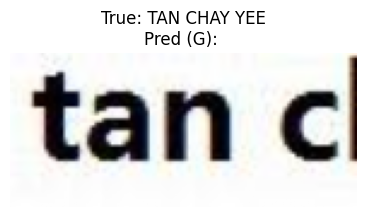


--- Test Example 2 ---
  True Label        : *** COPY ***
  Predicted (Greedy): 


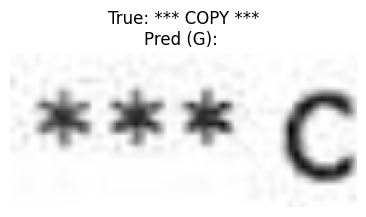


--- Test Example 3 ---
  True Label        : OJC MARKETING SDN BHD
  Predicted (Greedy): 


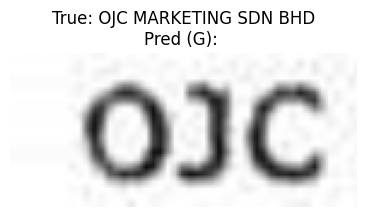


--- Test Example 4 ---
  True Label        : ROC NO: 538358-H
  Predicted (Greedy): 


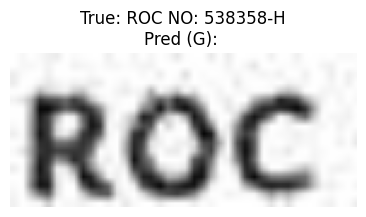


--- Test Example 5 ---
  True Label        : NO 2 & 4, JALAN BAYU 4,
  Predicted (Greedy): 


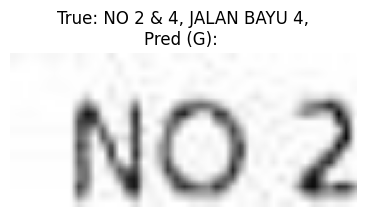


Prediction example display complete.


In [14]:
# Cell 11: Evaluation and Prediction Example (Using the Trained Model)

def ctc_decode_with_tf_nn(y_pred_logits, num_to_char_map):
    # y_pred_logits shape: (batch_size, time_steps, num_classes)

    logits_time_major = tf.transpose(y_pred_logits, perm=[1, 0, 2])

    num_time_steps = tf.shape(logits_time_major)[0]
    batch_s = tf.shape(logits_time_major)[1]

    logit_sequence_length = tf.fill(dims=(batch_s,), value=num_time_steps)

    decoded_list, neg_sum_logits = tf.nn.ctc_greedy_decoder(
        inputs=logits_time_major,
        sequence_length=logit_sequence_length,
        merge_repeated=True
    )

    sparse_tensor_output = decoded_list[0]

    try:
        decoded_sequences_num = tf.sparse.to_dense(sparse_tensor_output, default_value=-1).numpy()
    except TypeError as e:
        print(f"ERROR: Still got TypeError with tf.nn.ctc_greedy_decoder output: {e}")
        print(f"Type of object passed to tf.sparse.to_dense: {type(sparse_tensor_output)}")
        if hasattr(sparse_tensor_output, 'indices') and \
           hasattr(sparse_tensor_output, 'values') and \
           hasattr(sparse_tensor_output, 'dense_shape'):
            print("Attempting to manually create SparseTensor for to_dense...")
            try:
                st_manual = tf.SparseTensor(
                    indices=sparse_tensor_output.indices,
                    values=sparse_tensor_output.values,
                    dense_shape=sparse_tensor_output.dense_shape)
                decoded_sequences_num = tf.sparse.to_dense(st_manual, default_value=-1).numpy()
            except Exception as e_manual:
                print(f"Manual SparseTensor creation failed: {e_manual}")
                return ["<DECODE_ERROR_MANUAL_ST_FAILED>"] * batch_s.numpy()
        else:
            return ["<DECODE_ERROR_TYPE_UNKNOWN>"] * batch_s.numpy()

    decoded_texts = []
    for seq_num in decoded_sequences_num:
        text = "".join([num_to_char_map.get(num, '') for num in seq_num if num != -1 and num != CTC_BLANK_INDEX])
        decoded_texts.append(text)
    return decoded_texts


print("\nMaking predictions on some test examples...")

num_examples_to_show = 5
example_count = 0

#if BATCH_SIZE > 0:
    #num_batches_to_take = (num_examples_to_show + BATCH_SIZE - 1) // BATCH_SIZE
#else:
num_batches_to_take = 1

for batch_data in test_ds_batched.take(num_batches_to_take):
    input_dict, true_labels_encoded_batch = batch_data # Renamed for clarity
    images_batch = input_dict['image']

    preds_logits = crnn_model.predict(images_batch)

    decoded_preds_greedy = ctc_decode_with_tf_nn(preds_logits, num_to_char)

    for i in range(images_batch.shape[0]):
        if example_count >= num_examples_to_show:
            break

        # Get the specific label for the i-th sample from the batch
        current_true_label_encoded_numpy = true_labels_encoded_batch[i].numpy()

        # Now iterate over this specific sample's encoded label
        true_text = "".join([num_to_char.get(n, '') for n in current_true_label_encoded_numpy if n != -1 and n != CTC_BLANK_INDEX])

        print(f"\n--- Test Example {example_count + 1} ---")
        print(f"  True Label        : {true_text}")
        print(f"  Predicted (Greedy): {decoded_preds_greedy[i]}")

        plt.figure(figsize=(10,2))
        plt.imshow(images_batch[i].numpy())
        plt.title(f"True: {true_text}\nPred (G): {decoded_preds_greedy[i]}")
        plt.axis('off')
        plt.show()
        example_count += 1

    if example_count >= num_examples_to_show:
        break

print("\nPrediction example display complete.")